In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='7'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/ssd/al

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
def get_classification_loss(features, labels_all, video_ids):
    global ce_criterion
    labels_arr = []
    selected_probs_arr = []
    for iter_num in range(len(features)):
        cur_vid_feat = features[iter_num].T
        cur_vidid = video_ids[iter_num]
        labels = labels_all[iter_num]
        selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid + ".txt"], dtype=torch.long, 
                                       device=cur_vid_feat.device)
        selected_labels = labels[selected_frames]
        selected_probs = cur_vid_feat[selected_frames, :]
        
        labels_arr.append(selected_labels)
        selected_probs_arr.append(selected_probs)
        
    labels_arr = torch.cat(labels_arr)
    selected_probs_arr = torch.cat(selected_probs_arr)
    
    return ce_criterion(selected_probs_arr, labels_arr)

In [12]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [13]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [15]:
for epoch in range(1000):
    print("Starting Training")
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            loss += ce_criterion(p, boundary_target_tensor)
            loss += 0.15 * torch.mean(torch.clamp(
                mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                max=16) * src_mask_mse[:, :, 1:])

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    if epoch % 5 == 0:
        print("Calculating Validation Data Accuracy")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(testloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                
                pred = torch.argmax(predictions[-1], dim=1)
                correct += float(torch.sum((pred == item_2) * src_mask).item())
                total += float(torch.sum(src_mask).item())

        print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.664618492126465 Accuracy 2.481057792304264
Training:: Epoch 0, Iteration 10, Current loss 13.902303695678711 Accuracy 4.390785456563974
Training:: Epoch 0, Iteration 20, Current loss 12.930048942565918 Accuracy 19.981893429901707
Training:: Epoch 0, Iteration 30, Current loss 12.422285079956055 Accuracy 14.079311404857055
Training:: Epoch 0, Iteration 40, Current loss 11.979695320129395 Accuracy 7.010842779694431
Training:: Epoch 0, Iteration 50, Current loss 11.644539833068848 Accuracy 5.0834597875569045
Training:: Epoch 0, Iteration 60, Current loss 11.07874584197998 Accuracy 5.0526003852422585
Training:: Epoch 0, Iteration 70, Current loss 11.063798904418945 Accuracy 6.820054509729353
Training:: Epoch 0, Iteration 80, Current loss 10.39537525177002 Accuracy 10.014086310667178
Training:: Epoch 0, Iteration 90, Current loss 10.942529678344727 Accuracy 7.298772169167804
Training:: Epoch 0, Iteration 100, Current loss 10

Training:: Epoch 5, Iteration 60, Current loss 5.629953384399414 Accuracy 24.757574681206265
Training:: Epoch 5, Iteration 70, Current loss 3.899505138397217 Accuracy 48.69525959367946
Training:: Epoch 5, Iteration 80, Current loss 4.743191719055176 Accuracy 33.640492331995
Training:: Epoch 5, Iteration 90, Current loss 5.967964172363281 Accuracy 45.02266241396676
Training:: Epoch 5, Iteration 100, Current loss 5.064793109893799 Accuracy 41.04717835227844
Training:: Epoch 5, Iteration 110, Current loss 4.966911315917969 Accuracy 41.03070002367611
Training:: Epoch 5, Iteration 120, Current loss 5.202577114105225 Accuracy 45.81308713961775
Training:: Epoch 5, Iteration 130, Current loss 4.803657531738281 Accuracy 41.328596802841915
Training:: Epoch 5, Iteration 140, Current loss 4.6027750968933105 Accuracy 37.438042131350684
Training:: Epoch 5, Iteration 150, Current loss 4.8541741371154785 Accuracy 47.042988824537076
Calculating Validation Data Accuracy
Validation:: Epoch 5, Probability

Training:: Epoch 10, Iteration 130, Current loss 3.9755606651306152 Accuracy 69.03184961527224
Training:: Epoch 10, Iteration 140, Current loss 2.3381810188293457 Accuracy 66.64745990588688
Training:: Epoch 10, Iteration 150, Current loss 3.2484538555145264 Accuracy 77.97752808988764
Calculating Validation Data Accuracy
Validation:: Epoch 10, Probability Accuracy 50.0379086050462
Starting Training
Training:: Epoch 11, Iteration 0, Current loss 1.8433260917663574 Accuracy 62.32648528595225
Training:: Epoch 11, Iteration 10, Current loss 2.206193685531616 Accuracy 66.68054977092878
Training:: Epoch 11, Iteration 20, Current loss 1.902950644493103 Accuracy 76.40745622293353
Training:: Epoch 11, Iteration 30, Current loss 3.211918592453003 Accuracy 68.82549092256392
Training:: Epoch 11, Iteration 40, Current loss 2.6332545280456543 Accuracy 73.51932668329177
Training:: Epoch 11, Iteration 50, Current loss 3.0342042446136475 Accuracy 70.60726916999022
Training:: Epoch 11, Iteration 60, Curr

Training:: Epoch 16, Iteration 20, Current loss 2.973477840423584 Accuracy 78.07204719467805
Training:: Epoch 16, Iteration 30, Current loss 1.7825002670288086 Accuracy 71.37199624110619
Training:: Epoch 16, Iteration 40, Current loss 1.134177565574646 Accuracy 81.43336383043611
Training:: Epoch 16, Iteration 50, Current loss 1.0133440494537354 Accuracy 74.81119121180913
Training:: Epoch 16, Iteration 60, Current loss 1.2976866960525513 Accuracy 71.76873123385238
Training:: Epoch 16, Iteration 70, Current loss 1.879880428314209 Accuracy 72.59939548942107
Training:: Epoch 16, Iteration 80, Current loss 1.859548807144165 Accuracy 66.03391079985256
Training:: Epoch 16, Iteration 90, Current loss 1.7421222925186157 Accuracy 83.781140621783
Training:: Epoch 16, Iteration 100, Current loss 1.3329195976257324 Accuracy 82.43452791178498
Training:: Epoch 16, Iteration 110, Current loss 1.6094855070114136 Accuracy 79.38454043520623
Training:: Epoch 16, Iteration 120, Current loss 1.3988867998123

Training:: Epoch 21, Iteration 80, Current loss 1.1772027015686035 Accuracy 83.54126359330175
Training:: Epoch 21, Iteration 90, Current loss 1.2263929843902588 Accuracy 80.29252437703141
Training:: Epoch 21, Iteration 100, Current loss 1.685544490814209 Accuracy 78.43795798729849
Training:: Epoch 21, Iteration 110, Current loss 1.1901023387908936 Accuracy 80.76119143006444
Training:: Epoch 21, Iteration 120, Current loss 1.2744698524475098 Accuracy 82.1379781420765
Training:: Epoch 21, Iteration 130, Current loss 1.8735169172286987 Accuracy 73.08874986745838
Training:: Epoch 21, Iteration 140, Current loss 2.187990188598633 Accuracy 70.18147086914995
Training:: Epoch 21, Iteration 150, Current loss 1.4091788530349731 Accuracy 73.55765759260596
Starting Training
Training:: Epoch 22, Iteration 0, Current loss 1.0283654928207397 Accuracy 67.85255683964046
Training:: Epoch 22, Iteration 10, Current loss 1.302449107170105 Accuracy 80.24832245401014
Training:: Epoch 22, Iteration 20, Curren

Training:: Epoch 26, Iteration 140, Current loss 1.2385082244873047 Accuracy 78.51010101010101
Training:: Epoch 26, Iteration 150, Current loss 1.196557879447937 Accuracy 74.32491863840268
Starting Training
Training:: Epoch 27, Iteration 0, Current loss 1.3132156133651733 Accuracy 76.42770352369381
Training:: Epoch 27, Iteration 10, Current loss 1.0855109691619873 Accuracy 74.00946922501869
Training:: Epoch 27, Iteration 20, Current loss 1.4276865720748901 Accuracy 86.35492525871982
Training:: Epoch 27, Iteration 30, Current loss 1.0541410446166992 Accuracy 72.3202170963365
Training:: Epoch 27, Iteration 40, Current loss 0.6892832517623901 Accuracy 61.679618013294636
Training:: Epoch 27, Iteration 50, Current loss 1.0381993055343628 Accuracy 75.19019442096365
Training:: Epoch 27, Iteration 60, Current loss 0.7496564984321594 Accuracy 76.36982350905525
Training:: Epoch 27, Iteration 70, Current loss 1.3295836448669434 Accuracy 76.32323053812848
Training:: Epoch 27, Iteration 80, Current

Training:: Epoch 32, Iteration 30, Current loss 0.784907877445221 Accuracy 78.9171974522293
Training:: Epoch 32, Iteration 40, Current loss 0.8452825546264648 Accuracy 74.84003475787976
Training:: Epoch 32, Iteration 50, Current loss 1.067298412322998 Accuracy 77.9367816091954
Training:: Epoch 32, Iteration 60, Current loss 0.5532417297363281 Accuracy 77.98313422347154
Training:: Epoch 32, Iteration 70, Current loss 1.3030799627304077 Accuracy 84.78758270978913
Training:: Epoch 32, Iteration 80, Current loss 0.8031848669052124 Accuracy 78.90020012181328
Training:: Epoch 32, Iteration 90, Current loss 0.4707181751728058 Accuracy 79.08041300035603
Training:: Epoch 32, Iteration 100, Current loss 0.8900812864303589 Accuracy 85.09776759550323
Training:: Epoch 32, Iteration 110, Current loss 0.7653201818466187 Accuracy 74.43090582790214
Training:: Epoch 32, Iteration 120, Current loss 1.2139354944229126 Accuracy 74.08104850858692
Training:: Epoch 32, Iteration 130, Current loss 0.7876498103

Training:: Epoch 37, Iteration 90, Current loss 1.3018125295639038 Accuracy 69.76047904191617
Training:: Epoch 37, Iteration 100, Current loss 0.8037773966789246 Accuracy 72.94731582745794
Training:: Epoch 37, Iteration 110, Current loss 0.757719099521637 Accuracy 84.81998255886383
Training:: Epoch 37, Iteration 120, Current loss 0.9489984512329102 Accuracy 74.18881631797701
Training:: Epoch 37, Iteration 130, Current loss 0.9445183873176575 Accuracy 77.76825668856517
Training:: Epoch 37, Iteration 140, Current loss 0.8850764632225037 Accuracy 80.80357142857143
Training:: Epoch 37, Iteration 150, Current loss 0.8780725598335266 Accuracy 66.89419795221843
Starting Training
Training:: Epoch 38, Iteration 0, Current loss 0.8750118017196655 Accuracy 83.30613781850131
Training:: Epoch 38, Iteration 10, Current loss 0.707131564617157 Accuracy 82.2709432940858
Training:: Epoch 38, Iteration 20, Current loss 0.6256869435310364 Accuracy 83.26224783861672
Training:: Epoch 38, Iteration 30, Curre

Training:: Epoch 42, Iteration 150, Current loss 0.46576911211013794 Accuracy 86.50741888146095
Starting Training
Training:: Epoch 43, Iteration 0, Current loss 0.5141934156417847 Accuracy 81.02478650281192
Training:: Epoch 43, Iteration 10, Current loss 0.4533786475658417 Accuracy 86.88180255871683
Training:: Epoch 43, Iteration 20, Current loss 0.5493927001953125 Accuracy 82.02539550374688
Training:: Epoch 43, Iteration 30, Current loss 0.4359167218208313 Accuracy 79.73033207042567
Training:: Epoch 43, Iteration 40, Current loss 0.5482295155525208 Accuracy 84.49412799095647
Training:: Epoch 43, Iteration 50, Current loss 0.4471777081489563 Accuracy 76.82570593962998
Training:: Epoch 43, Iteration 60, Current loss 0.4254418909549713 Accuracy 86.37742010730115
Training:: Epoch 43, Iteration 70, Current loss 0.6132215857505798 Accuracy 69.78183962264151
Training:: Epoch 43, Iteration 80, Current loss 0.6845492124557495 Accuracy 78.9347290640394
Training:: Epoch 43, Iteration 90, Current

Training:: Epoch 48, Iteration 40, Current loss 1.6196078062057495 Accuracy 74.29989915444884
Training:: Epoch 48, Iteration 50, Current loss 0.6484573483467102 Accuracy 85.91268375563271
Training:: Epoch 48, Iteration 60, Current loss 1.7081228494644165 Accuracy 59.91799077396207
Training:: Epoch 48, Iteration 70, Current loss 1.8939533233642578 Accuracy 57.39092276830492
Training:: Epoch 48, Iteration 80, Current loss 1.26755952835083 Accuracy 60.95810705973623
Training:: Epoch 48, Iteration 90, Current loss 1.3438920974731445 Accuracy 79.02864643656861
Training:: Epoch 48, Iteration 100, Current loss 2.7114956378936768 Accuracy 73.11583729093537
Training:: Epoch 48, Iteration 110, Current loss 1.318811297416687 Accuracy 71.5345223379834
Training:: Epoch 48, Iteration 120, Current loss 3.8544368743896484 Accuracy 49.372362587468615
Training:: Epoch 48, Iteration 130, Current loss 1.0425692796707153 Accuracy 66.95154822168168
Training:: Epoch 48, Iteration 140, Current loss 1.99271738

Training:: Epoch 53, Iteration 100, Current loss 0.5673775672912598 Accuracy 80.37845963391989
Training:: Epoch 53, Iteration 110, Current loss 0.33707237243652344 Accuracy 72.08861509299847
Training:: Epoch 53, Iteration 120, Current loss 0.6426824331283569 Accuracy 76.73886590411293
Training:: Epoch 53, Iteration 130, Current loss 0.6644101738929749 Accuracy 85.28066932580991
Training:: Epoch 53, Iteration 140, Current loss 0.5826817750930786 Accuracy 75.69679355853066
Training:: Epoch 53, Iteration 150, Current loss 0.503989577293396 Accuracy 82.84086640791286
Starting Training
Training:: Epoch 54, Iteration 0, Current loss 0.4977918863296509 Accuracy 80.45588692140416
Training:: Epoch 54, Iteration 10, Current loss 0.4892454743385315 Accuracy 77.6937391199952
Training:: Epoch 54, Iteration 20, Current loss 0.5140408277511597 Accuracy 86.02595089683247
Training:: Epoch 54, Iteration 30, Current loss 0.48299291729927063 Accuracy 81.7298652460044
Training:: Epoch 54, Iteration 40, Cur

Training:: Epoch 58, Iteration 150, Current loss 0.4685680568218231 Accuracy 80.95013278253172
Starting Training
Training:: Epoch 59, Iteration 0, Current loss 0.7853716611862183 Accuracy 85.24777636594663
Training:: Epoch 59, Iteration 10, Current loss 0.3483595550060272 Accuracy 81.49237398262773
Training:: Epoch 59, Iteration 20, Current loss 0.42729106545448303 Accuracy 82.44808306709265
Training:: Epoch 59, Iteration 30, Current loss 0.42377156019210815 Accuracy 78.66486486486487
Training:: Epoch 59, Iteration 40, Current loss 0.48140111565589905 Accuracy 82.7889136352388
Training:: Epoch 59, Iteration 50, Current loss 0.46395620703697205 Accuracy 78.14928184600895
Training:: Epoch 59, Iteration 60, Current loss 0.5130746960639954 Accuracy 81.5059040024536
Training:: Epoch 59, Iteration 70, Current loss 0.6304601430892944 Accuracy 87.08680877355576
Training:: Epoch 59, Iteration 80, Current loss 0.43593835830688477 Accuracy 82.9955050462217
Training:: Epoch 59, Iteration 90, Curre

Training:: Epoch 64, Iteration 40, Current loss 1.0374678373336792 Accuracy 85.23775727466288
Training:: Epoch 64, Iteration 50, Current loss 0.585638165473938 Accuracy 71.83483290488432
Training:: Epoch 64, Iteration 60, Current loss 0.4615536332130432 Accuracy 71.10806230328464
Training:: Epoch 64, Iteration 70, Current loss 0.5565945506095886 Accuracy 80.71595994033667
Training:: Epoch 64, Iteration 80, Current loss 0.6938977241516113 Accuracy 78.33256563795486
Training:: Epoch 64, Iteration 90, Current loss 0.45407742261886597 Accuracy 73.8249170015726
Training:: Epoch 64, Iteration 100, Current loss 0.7585833072662354 Accuracy 75.00523194977328
Training:: Epoch 64, Iteration 110, Current loss 1.324840784072876 Accuracy 79.72201271414718
Training:: Epoch 64, Iteration 120, Current loss 0.8253192901611328 Accuracy 65.88791676519271
Training:: Epoch 64, Iteration 130, Current loss 1.2109684944152832 Accuracy 77.85038525309666
Training:: Epoch 64, Iteration 140, Current loss 1.0956548

Training:: Epoch 69, Iteration 100, Current loss 0.39123427867889404 Accuracy 86.49929201612025
Training:: Epoch 69, Iteration 110, Current loss 0.329881489276886 Accuracy 84.01034467383064
Training:: Epoch 69, Iteration 120, Current loss 0.3483869433403015 Accuracy 76.9843165353077
Training:: Epoch 69, Iteration 130, Current loss 0.4756404161453247 Accuracy 82.78735909047114
Training:: Epoch 69, Iteration 140, Current loss 0.4998505115509033 Accuracy 79.39817466681941
Training:: Epoch 69, Iteration 150, Current loss 0.5493791103363037 Accuracy 81.74872665534805
Starting Training
Training:: Epoch 70, Iteration 0, Current loss 0.43037518858909607 Accuracy 75.52325854851607
Training:: Epoch 70, Iteration 10, Current loss 0.4025217890739441 Accuracy 81.25316181253162
Training:: Epoch 70, Iteration 20, Current loss 0.44827964901924133 Accuracy 82.13794998625995
Training:: Epoch 70, Iteration 30, Current loss 0.4131915867328644 Accuracy 85.74506878833084
Training:: Epoch 70, Iteration 40, C

Training:: Epoch 74, Iteration 150, Current loss 0.6025605797767639 Accuracy 64.60756524288925
Starting Training
Training:: Epoch 75, Iteration 0, Current loss 0.7355557084083557 Accuracy 78.38296760710554
Training:: Epoch 75, Iteration 10, Current loss 0.5584880709648132 Accuracy 80.86721274517171
Training:: Epoch 75, Iteration 20, Current loss 0.8440248966217041 Accuracy 87.3217550274223
Training:: Epoch 75, Iteration 30, Current loss 0.6039531230926514 Accuracy 76.72737998672665
Training:: Epoch 75, Iteration 40, Current loss 0.6086082458496094 Accuracy 71.14427860696517
Training:: Epoch 75, Iteration 50, Current loss 1.0347744226455688 Accuracy 56.42661223448364
Training:: Epoch 75, Iteration 60, Current loss 0.7085978984832764 Accuracy 84.89900609169605
Training:: Epoch 75, Iteration 70, Current loss 1.5621459484100342 Accuracy 78.4837954754982
Training:: Epoch 75, Iteration 80, Current loss 0.8096140027046204 Accuracy 71.77660919922785
Training:: Epoch 75, Iteration 90, Current l

Exception in thread Thread-102:
Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as

KeyboardInterrupt: 

In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [17]:
torch.save(model.state_dict(), config.output_dir+'mstcn_single_frame.wt')

In [28]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [35]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(video_id_boundary_frames, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [ ]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        
        probs = get_ensemble_out([y, y_list])
        features = torch.log(probs + 1e-4).permute(0,2,1)
        get_estimated_boundary(features, item[1], item[4])
get_boundary_err()

In [ ]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = features[idx]
    cur_vidid = item[4][idx]

    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    bound_list = torch.tensor(boundaries_dict[cur_vidid], dtype=selected_frames.dtype, device=selected_frames.device)

    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)

    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat)

(0, 1)

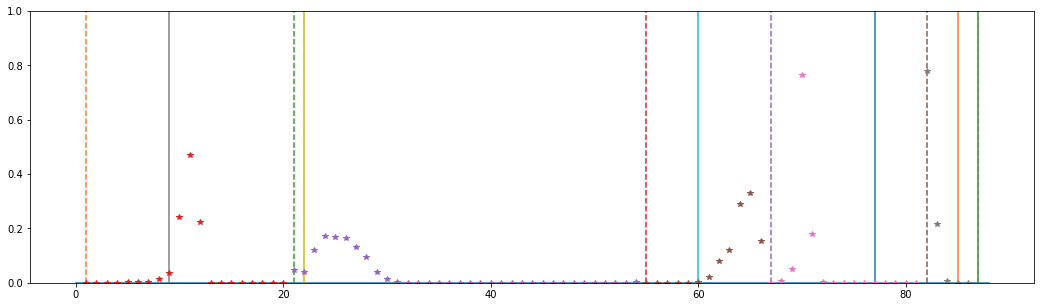

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob = segment / torch.sum(segment)
    prob = prob.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [49]:
np.max(prob), np.min(prob)

(5.1846523, 2.9907308)

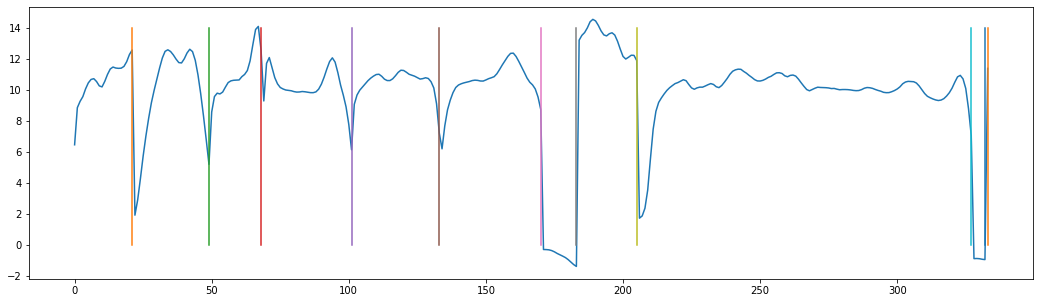

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss